# The Mandel & Agol (2002) $\Lambda$ function

#### Validation of the $\Lambda$ function for linearly limb-darkened transits

Let's import some stuff and define the numerical integral of a linearly limb-darkened source. We use scipy's `dblquad` function to compute the integral of $\sqrt{1 - x^2 - y^2}$ over the unocculted region of the source.

In [20]:
import numpy as np
from mpmath import ellipe, ellipk, ellippi
import matplotlib.pyplot as pl
from scipy.integrate import dblquad
%matplotlib inline

def NumericalFlux(b, r):
    """Compute the flux by numerical integration of the surface integral."""
    # I'm only coding up a specific case here
    b = np.abs(b)
    if b >= 1 + r:
        return 2 * np.pi / 3
    elif b <= r - 1:
        return 0

    # Total flux
    total = (np.pi / 6) * (6 - 2)
    if b >= 1 + r:
        return total

    # Get points of intersection
    if b > 1 - r:
        yi = (1. + b ** 2 - r ** 2) / (2. * b)
        xi = (1. / (2. * b)) * np.sqrt(4 * b ** 2 - (1 + b ** 2 - r ** 2) ** 2)
    else:
        yi = np.inf
        xi = r

    # Specific intensity map
    def I(y, x):
        return np.sqrt(1 - x ** 2 - y ** 2)

    # Lower integration limit
    def y1(x):
        if yi <= b:
            # Lower occultor boundary
            return b - np.sqrt(r ** 2 - x ** 2)
        elif b <= 1 - r:
            # Lower occultor boundary
            return b - np.sqrt(r ** 2 - x ** 2)
        else:
            # Tricky: we need to do this in two parts
            return b - np.sqrt(r ** 2 - x ** 2)

    # Upper integration limit
    def y2(x):
        if yi <= b:
            # Upper occulted boundary
            return np.sqrt(1 - x ** 2)
        elif b <= 1 - r:
            # Upper occultor boundary
            return b + np.sqrt(r ** 2 - x ** 2)
        else:
            # Tricky: we need to do this in two parts
            return np.sqrt(1 - x ** 2)

    # Compute the total flux
    flux, _ = dblquad(I, -xi, xi, y1, y2, epsabs=1e-14, epsrel=1e-14)

    # Do we need to solve an additional integral?
    if not (yi <= b) and not (b <= 1 - r):

        def y1(x):
            return b - np.sqrt(r ** 2 - x ** 2)

        def y2(x):
            return b + np.sqrt(r ** 2 - x ** 2)

        additional_flux, _ = dblquad(I, -r, -xi, y1, y2,
                                     epsabs=1e-14, epsrel=1e-14)

        flux += 2 * additional_flux

    return total - flux

Now we define the analytic functions in the paper:

In [ ]:
def s2(b, r):
    """The flux during the occultation."""
    b = np.abs(b)
    if b >= 1 + r:
        return 2 * np.pi / 3
    elif b <= r - 1:
        return 0
    return 2 * np.pi / 3 * (1 - 3 * Lambda(b, r) / 2 - int(r > b))


def Lambda(b, r):
    """The Mandel & Agol (2002) Lambda function."""
    ksq = (1 - r ** 2 - b ** 2 + 2 * b * r) / (4 * b * r)
    
    if ksq < 1:
        f1 = 1. / (9 * np.pi * np.sqrt(b * r))
        f2 = ((r + b) ** 2 - 1) / (r + b)
        f3 = -2 * r * (2 * (r + b) ** 2 + (r + b) * (r - b) - 3)
        f4 = 3 * (b - r)
        f5 = -4 * b * r * (4 - 7 * r ** 2 - b ** 2)
        K = float(ellipk(ksq))
        E = float(ellipe(ksq))
        PI = float(ellippi(ksq * (b + r) ** 2, ksq))
        return f1 * (f2 * (f3 * K + f4 * PI) + f5 * E)
    else:
        f1 = 2. / (9 * np.pi)
        f2 = 1 - (r + b) ** 2
        f3 = np.sqrt(1 - (b - r) ** 2)
        f4 = 3 * (b - r) / ((b + r) * np.sqrt(1 - (b - r) ** 2))
        f5 = -np.sqrt(1 - (b - r) ** 2) * (4 - 7 * r ** 2 - b ** 2)
        K = float(ellipk(1 / ksq))
        E = float(ellipe(1 / ksq))
        PI = float(ellippi(1 / (ksq * (b + r) ** 2), 1 / ksq))
        return f1 * (f2 * (f3 * K + f4 * PI) + f5 * E)

Let's compare the two for a simple transit:

In [22]:
r = 0.1
b = np.linspace(-1.5, 1.5, 100)
sol1 = np.array([NumericalFlux(b[i], r) for i in range(100)])
sol2 = np.array([s2(b[i], r) for i in range(100)])

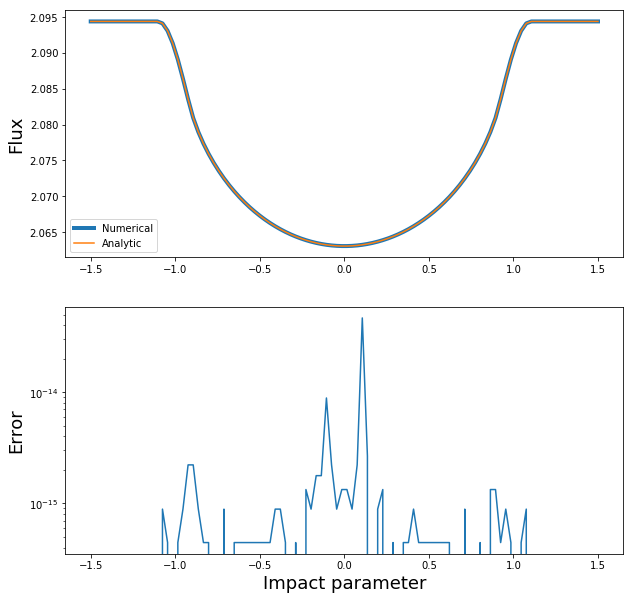

In [27]:
fig, ax = pl.subplots(2, figsize=(10, 10))
ax[0].plot(b, sol1, lw=4, label='Numerical')
ax[0].plot(b, sol2, label='Analytic')
ax[1].plot(b, np.abs(sol1 - sol2))
ax[1].set_yscale('log')
ax[0].legend();
ax[1].set_xlabel('Impact parameter', fontsize=18);
ax[0].set_ylabel('Flux', fontsize=18);
ax[1].set_ylabel('Error', fontsize=18);

Note that the error is mostly due to the numerical integration!

■